In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data

from combinators.inference import conditioning, variational
from combinators.lens import Cap, PRO, Ty
from combinators.model import collections
from combinators import sampler, signal, utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
torch.manual_seed(0xdeadbeef)

In [6]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [7]:
USE_CUDA = True

In [8]:
def generate_trajectory():
    x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, 1, Boundary)
    STATEs = np.zeros((T+1, 4))
    Disps = np.zeros((T, 2))
    init_state = np.array([x0[0], y0[0], init_v_rand_dir[0, 0], init_v_rand_dir[0, 1]])

    STATEs, Disps, _ = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)
    return STATEs, Disps

In [9]:
def dict_to_tracelike(d):
    return {k: v.expand(1, 1, *v.shape) for k, v in d.items()}

In [10]:
def generate_trajectory_trace(STATEs, Disps):
    data = {}

    for i, point in enumerate(STATEs):
        data['position_%d' % i] = point[:2]
        if i >= 1:
            data['velocity_%d' % (i-1)] = Disps[i-1]
    
    return data

In [11]:
import os.path

if os.path.isfile('examples/dynamical_ball/validation_trajectory.pt'):
    data = torch.load('examples/dynamical_ball/validation_trajectory.pt')
else:
    STATEs, Disps = generate_trajectory()
    STATEs = torch.tensor(STATEs, dtype=torch.float32)
    Disps = torch.tensor(Disps, dtype=torch.float32)
    data = generate_trajectory_trace(STATEs, Disps)
    torch.save(data, 'examples/dynamical_ball/validation_trajectory.pt')

In [12]:
if torch.cuda.is_available() and USE_CUDA:
    for k, v in data.items():
        data[k] = v.cuda()

In [13]:
p = dict_to_tracelike(data)
trajectory = torch.stack([p['position_%d' % t] for t in range(T+1)], dim=2)

In [14]:
num_particles = 3
particle_shape = (num_particles,)
batch_shape = (1,)

In [15]:
def accumulate_trajectory(p):
    initial_position = p['position_0'].value
    initial_velocity = p['velocity_0'].value
    velocities = torch.zeros(*initial_velocity.shape[:2], T + 1, 2).to(initial_velocity)
    velocities[:, :, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, :, t] = p['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, :, 0, :]

In [16]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, :, 0], positions[:, :, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [17]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [18]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [19]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))
    
    velocity_steps = velocity_steps.squeeze(-2)
    displacements = displacements.squeeze(-2)

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [20]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [21]:
def training_model(): 
    init_dynamics = dynamical_ball.InitBallDynamics()
    update = dynamical_ball.InitDynamicsProposal()
    init_dynamics = sampler.importance_box('init_dynamics', init_dynamics, update,
                                           batch_shape, particle_shape, PRO(0), PRO(2))
    init_state = dynamical_ball.InitialBallState()
    update = dynamical_ball.InitBallProposal()
    init_state = sampler.importance_box('init_state', init_state, update,
                                        batch_shape, particle_shape,
                                        PRO(0), PRO(2))
    
    step = dynamical_ball.StepBallState()
    update = dynamical_ball.StepBallProposal()
    step = sampler.importance_box('step_state', step, update, batch_shape, particle_shape, PRO(4), PRO(2))
    
    return (init_state @ init_dynamics) >> collections.sequential_ssm(PRO(2), PRO(2), step, T)

In [22]:
data_dicts = [data['position_%d' % t].unsqueeze(dim=0).detach()
              for t in range(T)]

diagram = training_model()
diagram = conditioning.SequentialConditioner(step_state=data_dicts)(diagram)
graph = sampler.compile(diagram >> signal.Cap(diagram.cod))

In [23]:
for box in graph:
    if isinstance(box, sampler.ImportanceWiringBox):
        state_dict = torch.load('examples/dynamical_ball/' + box.name + '_target.pt')
        box.sampler.target.load_state_dict(state_dict, strict=True)
        
        state_dict = torch.load('examples/dynamical_ball/' + box.name + '_proposal.pt')
        box.sampler.proposal.load_state_dict(state_dict, strict=True)
        
        if torch.cuda.is_available() and USE_CUDA:
            box.sampler.cuda()

In [24]:
num_iterations = 2000

In [25]:
graph = sampler.compile(diagram >> signal.Cap(diagram.cod))
filtering = sampler.filtering(graph)
smoothing = sampler.smoothing(graph)

In [26]:
step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)

  0%|                                                                                                                                                                                                                                                            | 0/2000 [00:00<?, ?it/s]

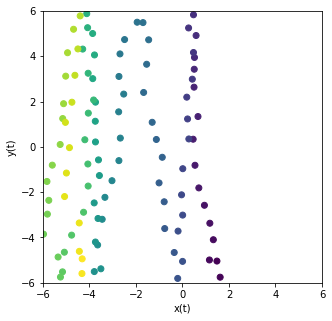

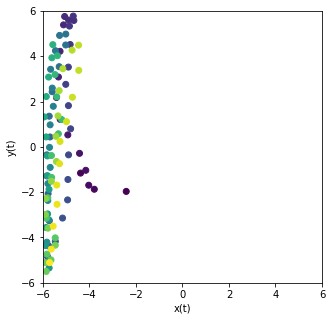

 10%|████████████████████████▏                                                                                                                                                                                                                         | 200/2000 [06:20<56:05,  1.87s/it]

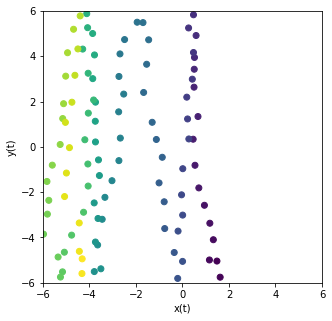

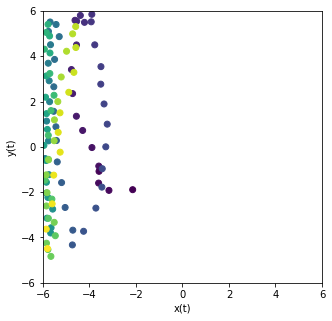

 20%|████████████████████████████████████████████████▍                                                                                                                                                                                                 | 400/2000 [12:36<50:09,  1.88s/it]

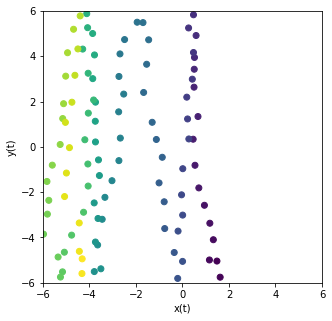

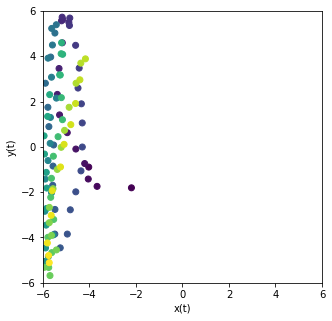

 30%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                         | 600/2000 [18:55<42:16,  1.81s/it]

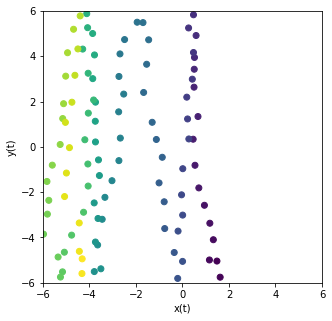

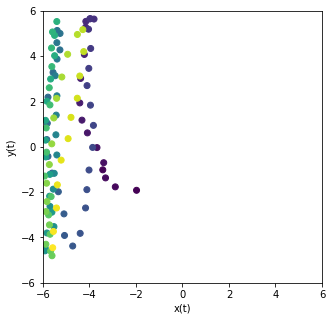

 40%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 800/2000 [25:13<37:52,  1.89s/it]

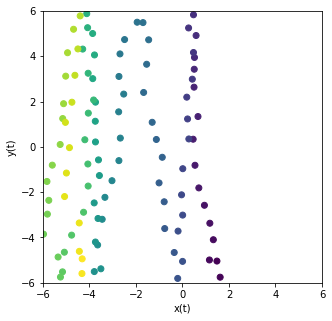

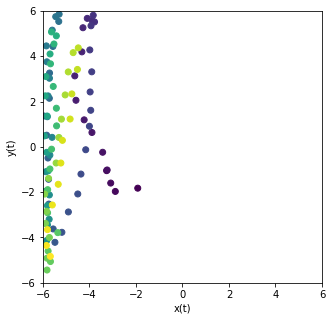

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 1000/2000 [31:24<29:47,  1.79s/it]

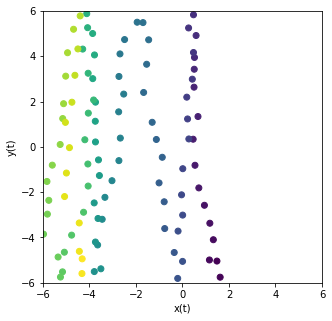

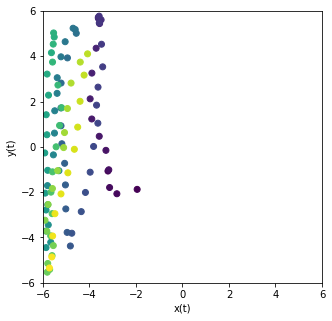

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1200/2000 [37:19<22:54,  1.72s/it]

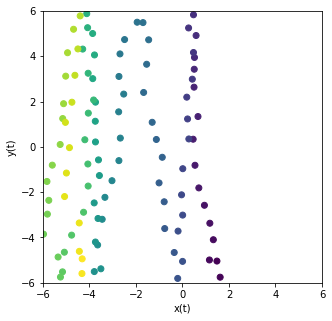

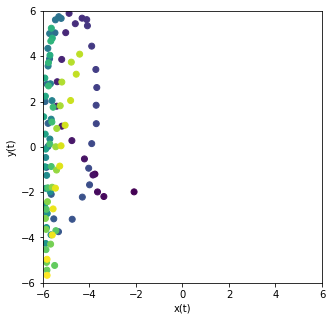

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1400/2000 [42:59<17:43,  1.77s/it]

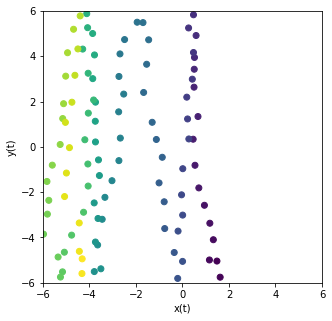

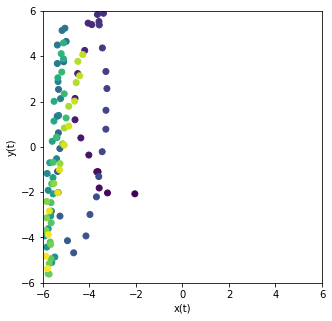

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1600/2000 [48:44<12:02,  1.81s/it]

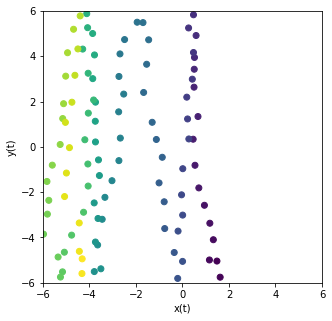

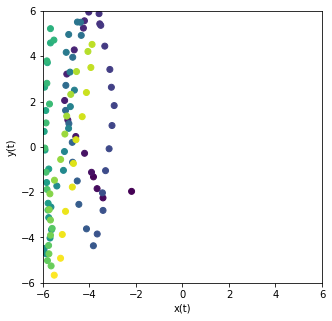

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1800/2000 [54:48<06:01,  1.81s/it]

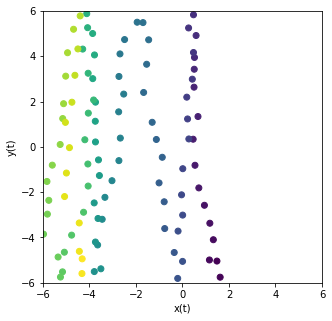

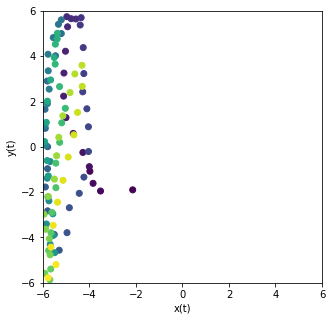

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:00:58<00:00,  1.83s/it]


In [27]:
from tqdm import tqdm

with torch.no_grad():
    filtering()

    for i in tqdm(range(num_iterations)):
        smoothing()

        if i % (num_iterations // 10) == 0:
            p, log_weight = sampler.trace(graph)
            inferred_trajectory = accumulate_trajectory(p)

            positions = inferred_trajectory.mean(dim=0).cpu().detach()
            displacements = torch.stack([p['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
            velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).unsqueeze(1).to(displacements), displacements[:-1]), dim=2)
            velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).unsqueeze(1).to(displacements) + 1, displacements[:-1]), dim=2)
            velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)

            graph_original_trajectory(trajectory.cpu().squeeze(dim=0), T, 0)
            graph_inferred_trajectory(positions, T, 0)
            graph_displacement_trajectories(velocity_steps, displacements, T, 0)

            plt.close('all')

In [29]:
if torch.cuda.is_available() and USE_CUDA:
    for k, v in data.items():
        data[k] = v.cpu()

In [30]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])
    print('Inferred position at time %d' % t, positions[:, t])
    print('MSE at time %d' % t, ((data['position_%d' % t] - positions[:, t])**2).sum())

Position at time 0 tensor([ 1.4834, -5.0403])
Inferred position at time 0 tensor([[-2.1400, -1.8964]])
MSE at time 0 tensor(23.0133)
Position at time 1 tensor([ 1.6224, -5.7522])
Inferred position at time 1 tensor([[-3.9815, -1.0770]])
MSE at time 1 tensor(53.2614)
Position at time 2 tensor([ 1.1603, -4.9917])
Inferred position at time 2 tensor([[-3.5230, -1.9476]])
MSE at time 2 tensor(31.1998)
Position at time 3 tensor([ 1.3284, -4.0980])
Inferred position at time 3 tensor([[-3.8441, -1.6083]])
MSE at time 3 tensor(32.9534)
Position at time 4 tensor([ 1.1784, -3.3703])
Inferred position at time 4 tensor([[-4.0054, -0.8724]])
MSE at time 4 tensor(33.1115)
Position at time 5 tensor([ 0.9453, -2.5773])
Inferred position at time 5 tensor([[-4.2835, -0.2451]])
MSE at time 5 tensor(32.7796)
Position at time 6 tensor([ 0.7048, -1.8100])
Inferred position at time 6 tensor([[-4.6965,  0.5959]])
MSE at time 6 tensor(34.9621)
Position at time 7 tensor([ 0.5399, -0.8113])
Inferred position at ti